In [19]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import pandas as pd

### The file 'nntools.py' is introduced from ECE 285 Machine Learning and Image Processing

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Dataset

In [21]:
dataset_root_dir = './dataset/'

In [22]:
class CarDataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(224, 224)):
        super(CarDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.data = pd.read_csv(os.path.join(root_dir, "%sdata.csv" % mode))
        self.images_dir = os.path.join(root_dir, "cars_" + self.mode)
        self.files = sorted(os.listdir(self.images_dir))
    def __len__(self):
        return len(self.data)
    def __repr__(self):
        return "CarDataset(mode={}, image_size={})".format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        bbox = self.data.iloc[idx][['bbox1', 'bbox2', 'bbox3', 'bbox4']]
        img = Image.open(img_path).convert('RGB')
        img = img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])
        transform = tv.transforms.Compose([tv.transforms.Resize(self.image_size), tv.transforms.ToTensor(), 
                                           tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        x = transform(img)
        d = self.data.iloc[idx]['class']
        return x, d
    def number_of_classes(self):
        return self.data['class'].max() + 1

In [23]:
train_set = CarDataset(dataset_root_dir)

In [24]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [25]:
x,d = train_set.__getitem__(10)

In [26]:
val_set = CarDataset(dataset_root_dir, mode='test')

# Model

In [27]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.mse = nn.MSELoss()
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

In [28]:
class VGG16Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True) 
        for param in vgg.parameters():
            param.requires_grad = fine_tuning 
        self.features = vgg.features
        self.classifier = vgg.classifier
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x): 
        f = self.features(x)
        f = f.view(-1, self.classifier[0].in_features)
        y = self.classifier(f) 
        return y

# VGG16

In [29]:
num_classes = train_set.number_of_classes()
vgg16 = VGG16Transfer(num_classes)

In [30]:
print(vgg16)

VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (mse): MSELoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [31]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
        self.topk_accuracy = 0
        
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        _, topl = torch.topk(y, k=3, dim=1)
        self.running_accuracy += torch.mean((l == d).float())
        num = y.size()[0]
        truecount = 0
        for i in range(num):
            if d[i] in topl[i,:]:
                truecount += 1
        self.topk_accuracy += truecount/num
        
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy/self.number_update
        topkacc = 100 * self.topk_accuracy/self.number_update
        return {'loss': loss, 'accuracy': accuracy, 'top3accuracy':topkacc}


In [32]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
                     output_dir="carset", perform_validation_during_training=True)

In [33]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                label="evaluation loss")
    axes[0].legend()
    axes[0].xlabel('Epoch')
    axes[0].ylabel('Loss')
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],
                label="traning accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
                label="evaluation accuracy")
    axes[1].legend()
    axes[1].xlabel('Epoch')
    axes[1].ylabel('Accuracy(%)')
    plt.tight_layout()
    fig.canvas.draw()

In [35]:
def topplot(exp, fig, axes, name):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                label="evaluation loss")
    axes[0].legend(prop={'size': 6})
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    title_tmp = name+' Training and Evaluation Loss'
    axes[0].set_title(title_tmp, {'fontsize':8})
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],
                label="training accuracy")
    axes[1].plot([exp.history[k][0]['top3accuracy'] for k in range(exp.epoch)],
                label="top 3 training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
                label="evaluation accuracy")
    axes[1].plot([exp.history[k][1]['top3accuracy'] for k in range(exp.epoch)],
                label="top 3 evaluation accuracy")
    axes[1].legend(prop={'size': 6})
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy(%)')
    title_tmp = name+' Training and Evaluation Accuracy'
    axes[1].set_title(title_tmp, {'fontsize':8})
    plt.tight_layout()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


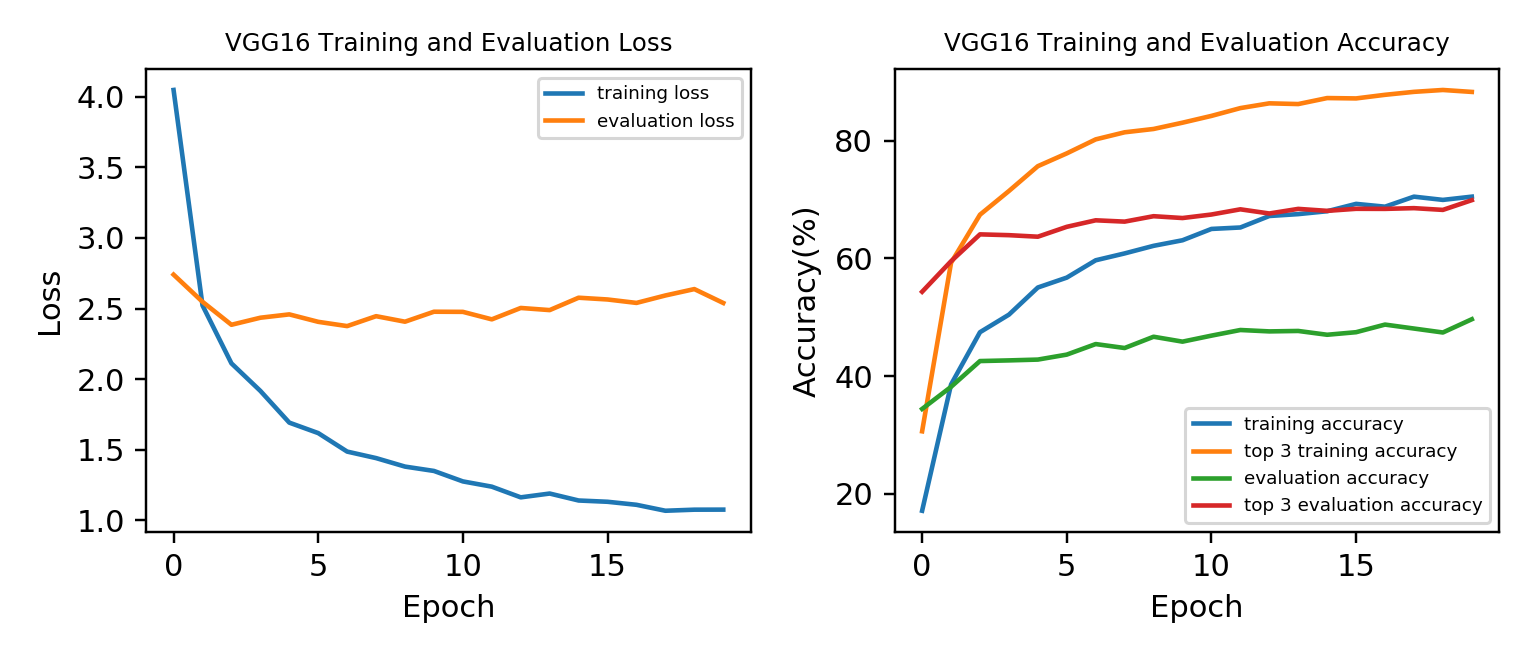

Start/Continue training from epoch 20
Finish training for 20 epochs


In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: topplot(exp, fig=fig, axes=axes, name='VGG16'))

# Resnet18

In [38]:
resnet = tv.models.resnet18(pretrained=True)

In [39]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [40]:
class ResNet18Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(ResNet18Transfer, self).__init__()
        self.resnet = tv.models.resnet18(pretrained=True) 
        for param in self.resnet.parameters():
            param.requires_grad = fine_tuning 
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x): 
        return self.resnet(x)

In [41]:
num_classes = train_set.number_of_classes()

In [42]:
lr = 1e-3
net = ResNet18Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
                     output_dir="carset_resnet", perform_validation_during_training=True)

ValueError: Cannot create this experiment: I found a checkpoint conflicting with the current setting.

<IPython.core.display.Javascript object>


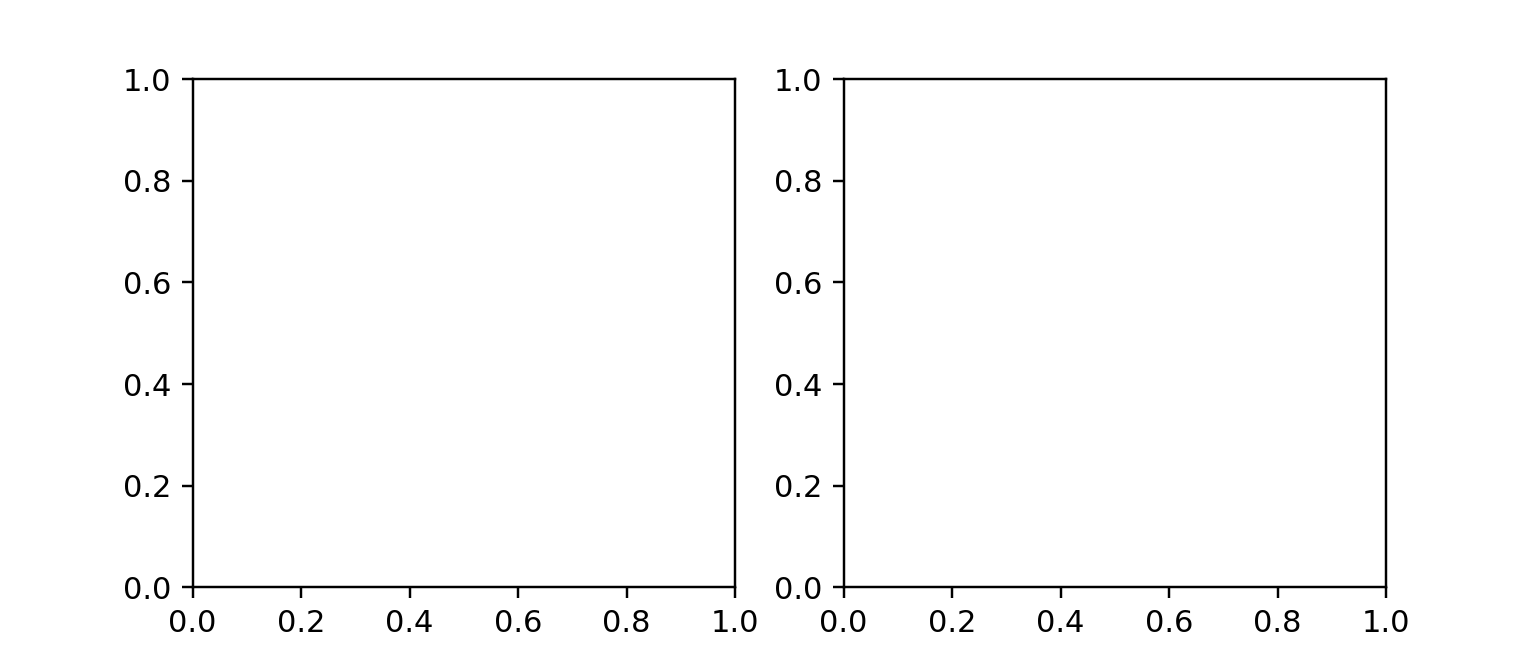

NameError: name 'exp2' is not defined

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=20, plot=lambda exp: topplot(exp, fig=fig, axes=axes, name='Resnet18'))

# Resnet50

In [53]:
class ResNet50Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(ResNet50Transfer, self).__init__()
        self.resnet = tv.models.resnet50(pretrained=True) 
        for param in self.resnet.parameters():
            param.requires_grad = fine_tuning 
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x): 
        return self.resnet(x)

In [54]:
num_classes = train_set.number_of_classes()

In [55]:
lr = 1e-3
net = ResNet50Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp3 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
                     output_dir="carset_resnet50", perform_validation_during_training=True)

ValueError: Cannot create this experiment: I found a checkpoint conflicting with the current setting.

<IPython.core.display.Javascript object>


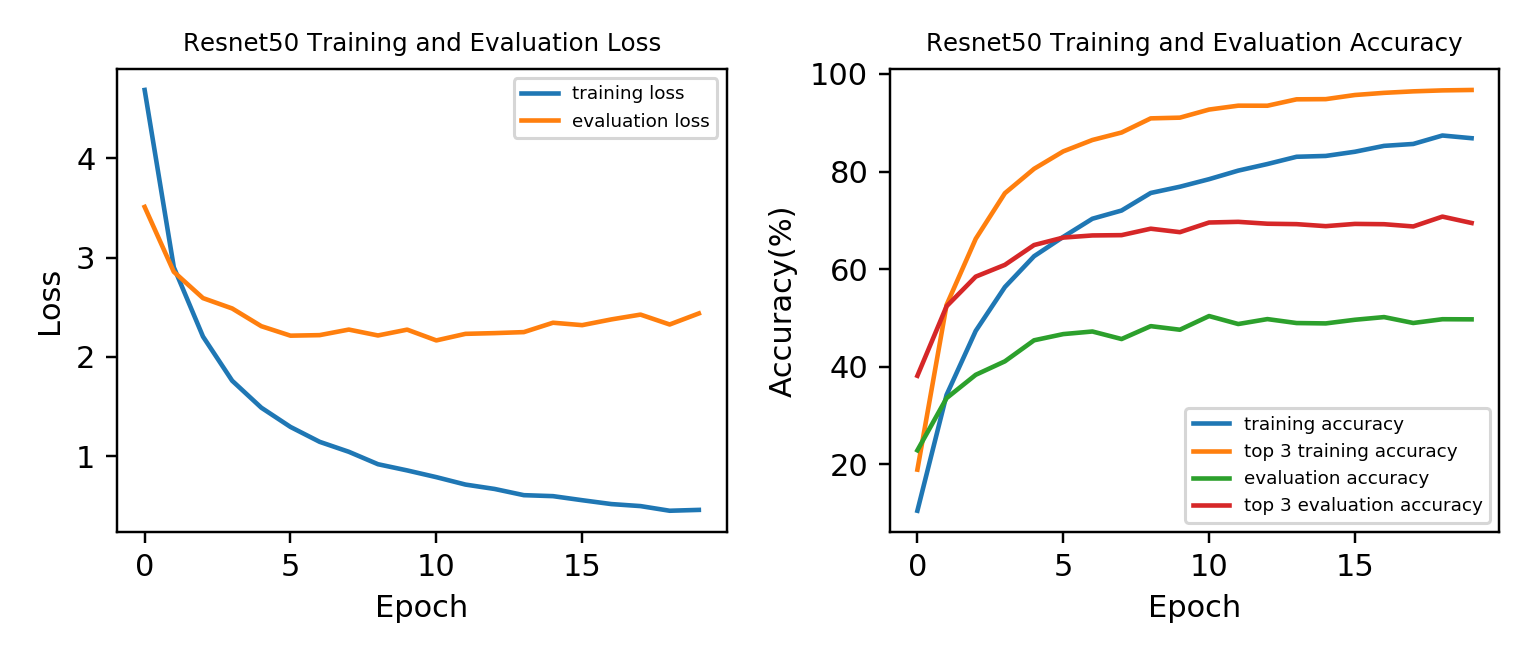

Start/Continue training from epoch 20
Finish training for 20 epochs


In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp3.run(num_epochs=20, plot=lambda exp: topplot(exp, fig=fig, axes=axes, name='Resnet50'))

# Resnet18 finetuning

In [15]:
lr = 1e-3
net = ResNet18Transfer(num_classes, fine_tuning=True)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp5 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
                     output_dir="carset_resnet18_fine", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


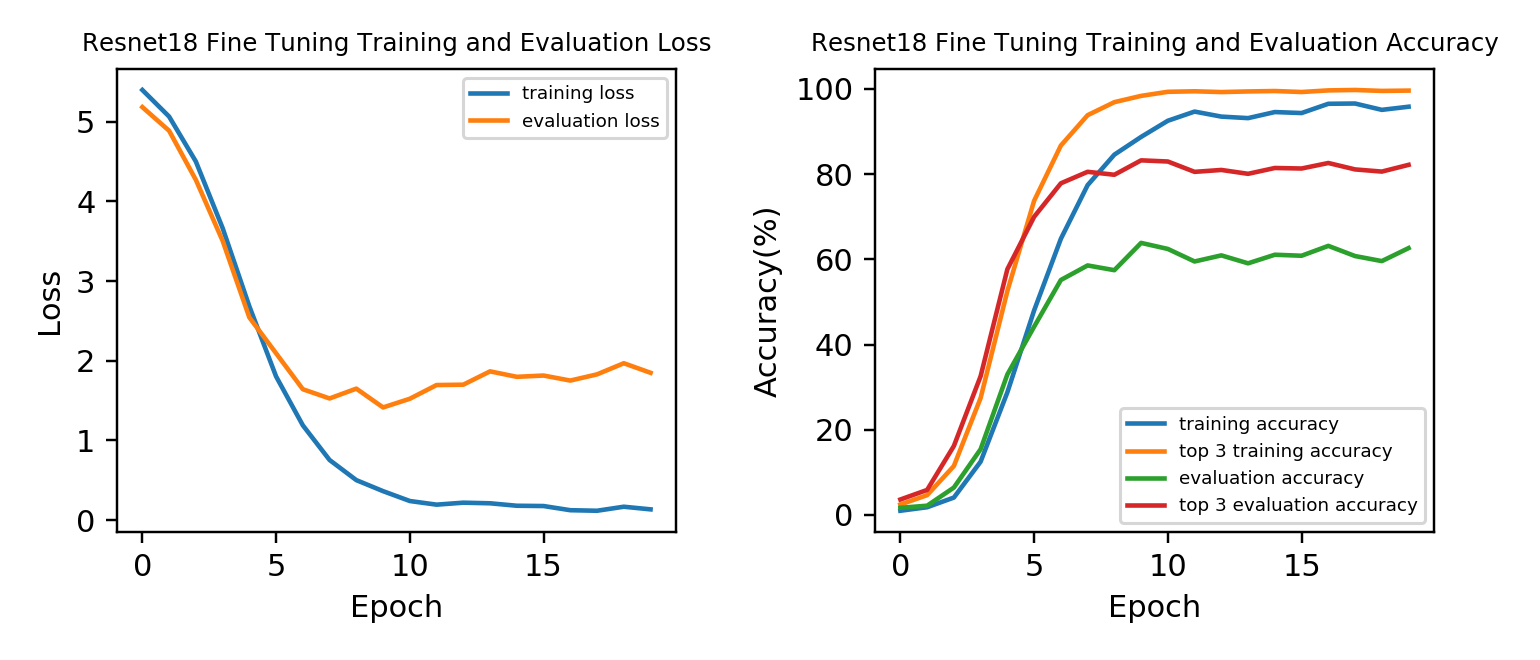

Start/Continue training from epoch 20
Finish training for 20 epochs


In [67]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp5.run(num_epochs=20, plot=lambda exp: topplot(exp, fig=fig, axes=axes, name='Resnet18 Fine Tuning'))

# Resnet50_fine_tuning

In [69]:
lr = 1e-3
net = ResNet50Transfer(num_classes, fine_tuning=True)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp6 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
                     output_dir="carset_resnet50_fine", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


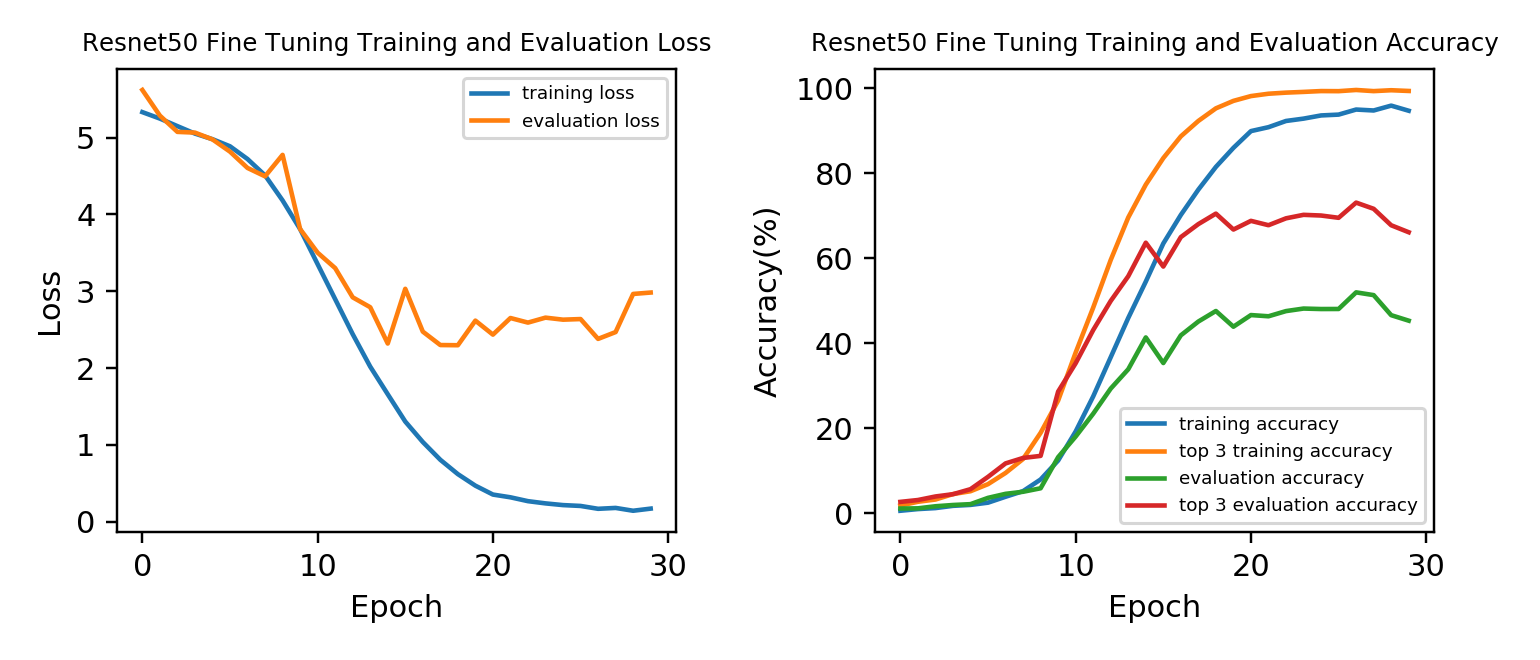

Start/Continue training from epoch 30
Finish training for 20 epochs


In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp6.run(num_epochs=20, plot=lambda exp: topplot(exp, fig=fig, axes=axes, name='Resnet50 Fine Tuning'))